# 1. Define Problems

- Predicting prices for new listing house
- Analyzing most influence factor for consumer

# Import Common Package

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value, plot_actual_vs_prediction,plot_residual
from jcopml.feature_importance import mean_score_decrease

# Import Data

In [3]:
df = pd.read_csv("data/house_price.csv",index_col="ID")

In [4]:
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
ID,,,,,,,,,,,,,,
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9


## Data Cleaning 

,missing_value,%
crim,0,0.0
zn,0,0.0
indus,0,0.0
chas,0,0.0
nox,0,0.0
rm,0,0.0
age,0,0.0
dis,0,0.0
rad,0,0.0
tax,0,0.0


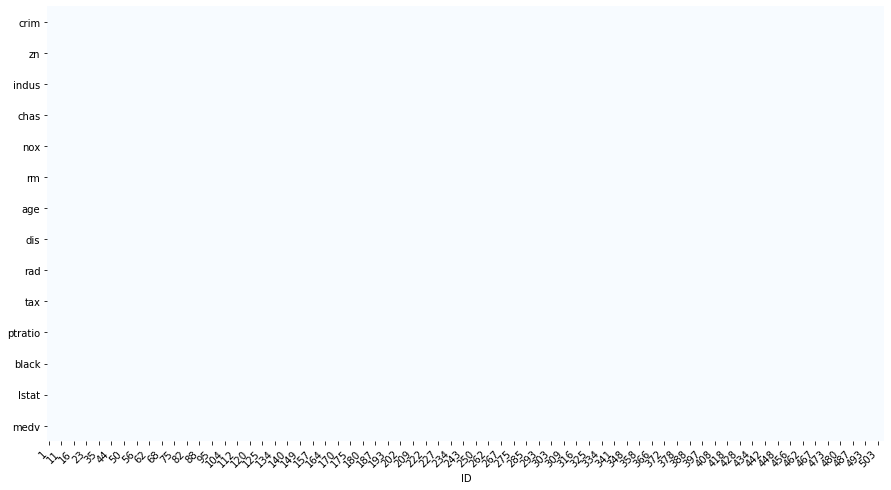

In [5]:
plot_missing_value(df,return_df=True)

The dataset already clean, so let get work

# 2. Exploratory Data Analysist 

In [6]:
df.shape

(333, 14)

In [7]:
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
ID,,,,,,,,,,,,,,
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9


## Data Splitting

In [8]:
X = df.drop(columns="medv")
y = df.medv

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((266, 13), (67, 13), (266,), (67,))

In [9]:
df.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'black', 'lstat', 'medv'],
      dtype='object')

# 3. Training 

In [10]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ["crim","zn","indus","nox","rm","age","dis","tax","ptratio","black","lstat"]),
    ('categoric', cat_pipe(encoder='onehot'), ["rad","chas"]),
])

In [11]:
from sklearn.linear_model import LinearRegression
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LinearRegression())
])

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

model = RandomizedSearchCV(pipeline, rsp.linreg_params, cv=5, n_iter=100, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

C:\Users\Ferdian\miniconda3\envs\jcop_usl\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 2 is smaller than n_iter=100. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'algo__fit_intercept': False}
0.7374737857550149 0.6852017096115505 0.7513052403069953


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.1s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.1s finished


We get **R^2 : 0.6852** for accuracy this model, it's still have to be improved, so i want to know why this happend? Then I plot actual vs prediction to look how my model in train and test, and residual plot to improve model

# 4. Evaluation

### Actual vs Prediction Plot

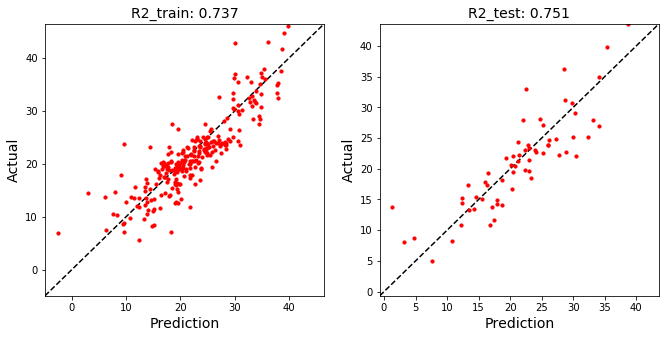

In [13]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model)

### Residual

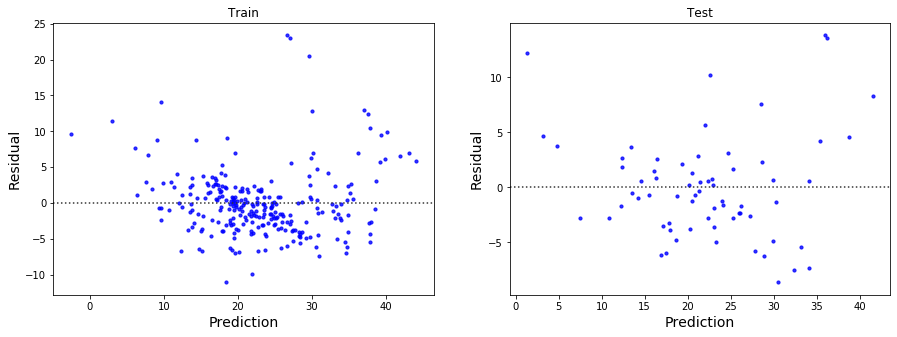

In [14]:
plot_residual(X_train, y_train, X_test, y_test, model)

- In training, model have good prediction house with price USD 20 - 28 but not good for USD 28-40
- In test, model not good at all as we can look just some data that have 0 residual
- If we look the pattern, they have an arch which mean the data non linear

# 5. Optimizing 

## Optimizing 1 : Polynomial

Because the data is not linear, so we have to use polynomial degree 

In [89]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=10), ["crim","zn","indus","nox","rm","age","dis","tax","ptratio","black","lstat"]),
    ('categoric', cat_pipe(encoder='onehot'), ["rad","chas"]),
])

In [90]:
from sklearn.linear_model import LinearRegression
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LinearRegression())
])

In [91]:
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [93]:
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

model = RandomizedSearchCV(pipeline, rsp.linreg_poly_params,cv=5, n_iter=10, n_jobs=-1, verbose=1,)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


{'algo__fit_intercept': False, 'prep__numeric__poly__degree': 2, 'prep__numeric__poly__interaction_only': True}
0.9238321192012439 0.8137045781281029 0.8019542974056857


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished


We have better model right now **R^2 = 0.8137** , but we have overfitting problem rightnow. So let's done this probs

## Optimizing 2 : Feature Selection

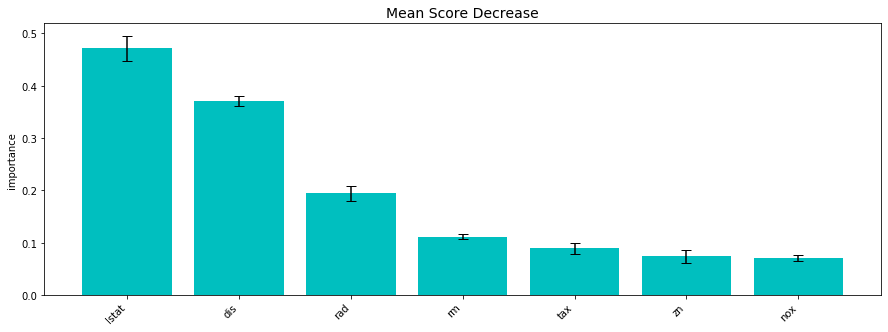

In [19]:
df_imp =  mean_score_decrease(X_train, y_train, model, plot=True, topk=7, n_fold=5, normalize=False)

In [20]:
df_imp.feature.values

array(['lstat', 'dis', 'rad', 'rm', 'tax', 'zn', 'nox'], dtype=object)

## Optimizing 3: Use Elastic Net

Because the model overfitting, we have to regularize the model with punisment. I'm using ElasticNet for combining Lasso and Ridge methode for better result

In [113]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2), ['lstat', 'rm', 'dis', 'age', 'tax', 'indus']),
    ('categoric', cat_pipe(encoder='onehot'), ["rad","chas"]),
])

In [114]:
from sklearn.linear_model import ElasticNet
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', ElasticNet())
])

from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

model = RandomizedSearchCV(pipeline, rsp.enet_params, cv=5, n_iter=50, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))



Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s


{'algo__alpha': 1.0403917340213404, 'algo__fit_intercept': True, 'algo__l1_ratio': 0.22106988571684522}
0.8580812953320475 0.8041544693646825 0.8729330322935228


[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.6s finished
C:\Users\Ferdian\miniconda3\envs\jcop_usl\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1735.87590021851, tolerance: 2.1895614736842104
  positive)


Sekarang kita memiliki model dengan akurasi yang cukup baik dan good fit.
Now we have good models after we use regularization with parameter :
- alpha : 0.0004
- l1_ratio : 0.688 which mean combination between lasso and ridge

## Using Random Forest Regressor

Now, i want to use another algorithm for this data. I'm using Random Forest for this project because this is one of most popular alghorithm with good concept.

In [221]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ["crim","zn","indus","nox","rm","age","dis","tax","ptratio","black","lstat"]),
    ('categoric', cat_pipe(), ["rad","chas"]),
])

In [224]:
from sklearn.ensemble import RandomForestRegressor
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])

In [226]:
from jcopml.tuning.space import Integer,Real

In [227]:
gsp.rf_params

{'algo__n_estimators': [100, 150, 200],
 'algo__max_depth': [20, 50, 80],
 'algo__max_features': [0.3, 0.6, 0.8],
 'algo__min_samples_leaf': [1, 5, 10]}

In [233]:
gsp.parameter = {'algo__n_estimators': [100, 150, 220],
 'algo__max_depth': [20, 80, 100],
 'algo__max_features': [0.6, 0.8, 0.9],
 'algo__min_samples_leaf': [2, 5, 10]}

In [235]:
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

model = GridSearchCV(pipeline, gsp.parameter, cv=5, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:   55.8s finished


{'algo__max_depth': 20, 'algo__max_features': 0.6, 'algo__min_samples_leaf': 2, 'algo__n_estimators': 100}
0.957508557185977 0.820877704288432 0.9134415727112615


## Using XGBoost

In [291]:
from jcopml.tuning.space import Integer,Real

In [292]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ["crim","zn","indus","nox","rm","age","dis","tax","ptratio","black","lstat"]),
    ('categoric', cat_pipe(), ["rad","chas"]),
])

In [293]:
from xgboost import XGBRegressor
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(max_depth=2,n_jobs=-1, random_state=42))
])

In [294]:
rsp.xgb_poly_params

{'prep__numeric__poly__degree': Integer(low=1, high=3),
 'prep__numeric__poly__interaction_only': [True, False],
 'algo__max_depth': Integer(low=1, high=10),
 'algo__learning_rate': Real(low=-2, high=0, prior='log-uniform'),
 'algo__n_estimators': Integer(low=100, high=200),
 'algo__subsample': Real(low=0.3, high=0.8, prior='uniform'),
 'algo__gamma': Integer(low=1, high=10),
 'algo__colsample_bytree': Real(low=0.1, high=1, prior='uniform'),
 'algo__reg_alpha': Real(low=-3, high=1, prior='log-uniform'),
 'algo__reg_lambda': Real(low=-3, high=1, prior='log-uniform')}

In [296]:
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=5, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.2s


{'algo__colsample_bytree': 0.8284250399306623, 'algo__gamma': 3, 'algo__learning_rate': 0.03253972566577117, 'algo__max_depth': 8, 'algo__n_estimators': 112, 'algo__reg_alpha': 0.002120199469953843, 'algo__reg_lambda': 0.0010489129591818502, 'algo__subsample': 0.6139472074743181}
0.9884336597196703 0.8474476913864898 0.9149078518251367


[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    4.5s finished


In [266]:
df.iloc[4:5]

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
ID,,,,,,,,,,,,,,
7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.6,12.43,22.9


## 7. Prediction

In [279]:
x_pred = pd.DataFrame([[0.1, 5, 5, 1, 0.4, 4, 20, 1, 1, 250, 12, 120, 10]], columns=X_train.columns)

In [280]:
x_pred

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,0.1,5,5,1,0.4,4,20,1,1,250,12,120,10


In [282]:
a = model.predict(x_pred)

In [286]:
a

array([28.11307262])

In [285]:
y_test.describe()

count    67.000000
mean     22.373134
std       9.558347
min       5.000000
25%      15.300000
50%      22.000000
75%      25.150000
max      50.000000
Name: medv, dtype: float64